In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [4]:
train_images = (train_images - 127.5) / 127.5

In [5]:
train_images[:5][0][:1]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.]])

In [6]:
train_images = train_images.reshape(BUFFER_SIZE, 28, 28, 1)
train_images.shape

(60000, 28, 28, 1)

In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [9]:
NOISE_DIM = 100
LABEL_DIM = 10

def create_generator():
    label_input = layers.Input(shape=(10,))
    noise_input = layers.Input(shape=(100,))
    
    x = layers.Concatenate()([label_input, noise_input])
    x = layers.Dense(7*7*256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    
    x = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    output = layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=[label_input, noise_input], outputs=output)
    
generator_model = create_generator()
generator_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 110)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12544)     │  1,392,384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12544)     │     50,176 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    295,040 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │     73,792 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 28, 28,    │     18,464 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28, 1) │        289 │ leaky_re_lu_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,830,913 (6.98 MB)

 Trainable params: 1,805,441 (6.89 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [10]:
def create_discriminator():
    image_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(10,))
    
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)    
    x = layers.Concatenate()([x, label_input])
    
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[image_input, label_input], outputs=output)
    
    return model

discriminator_model = create_discriminator()
discriminator_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 4, 4, 256) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 256) │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2, 512) │  1,180,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 2, 2, 512) │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 2, 512) │          0 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2058)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  1,054,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 512)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        513 │ dropout_4[0][0] 

 Total params: 2,604,545 (9.94 MB)

 Trainable params: 2,604,545 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


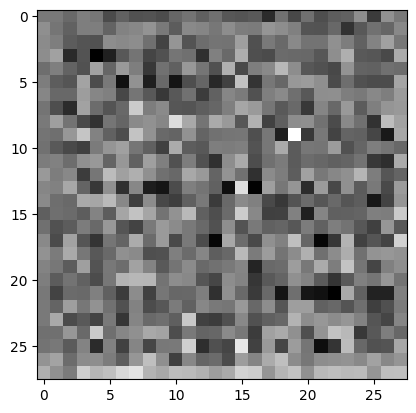

In [12]:
noise = np.random.normal(0, 1, (1, 100))
labels = tf.keras.utils.to_categorical([[1]], 10)

test_image = generator_model.predict([labels, noise])
plt.imshow(test_image[0, :, :, 0], cmap='gray')

In [13]:
# Loss Functions
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    return real_loss + fake_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
@tf.function
def train_step(generator, discriminator, images, labels):
    noise = tf.random.normal([images.shape[0], NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([labels, noise], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [15]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

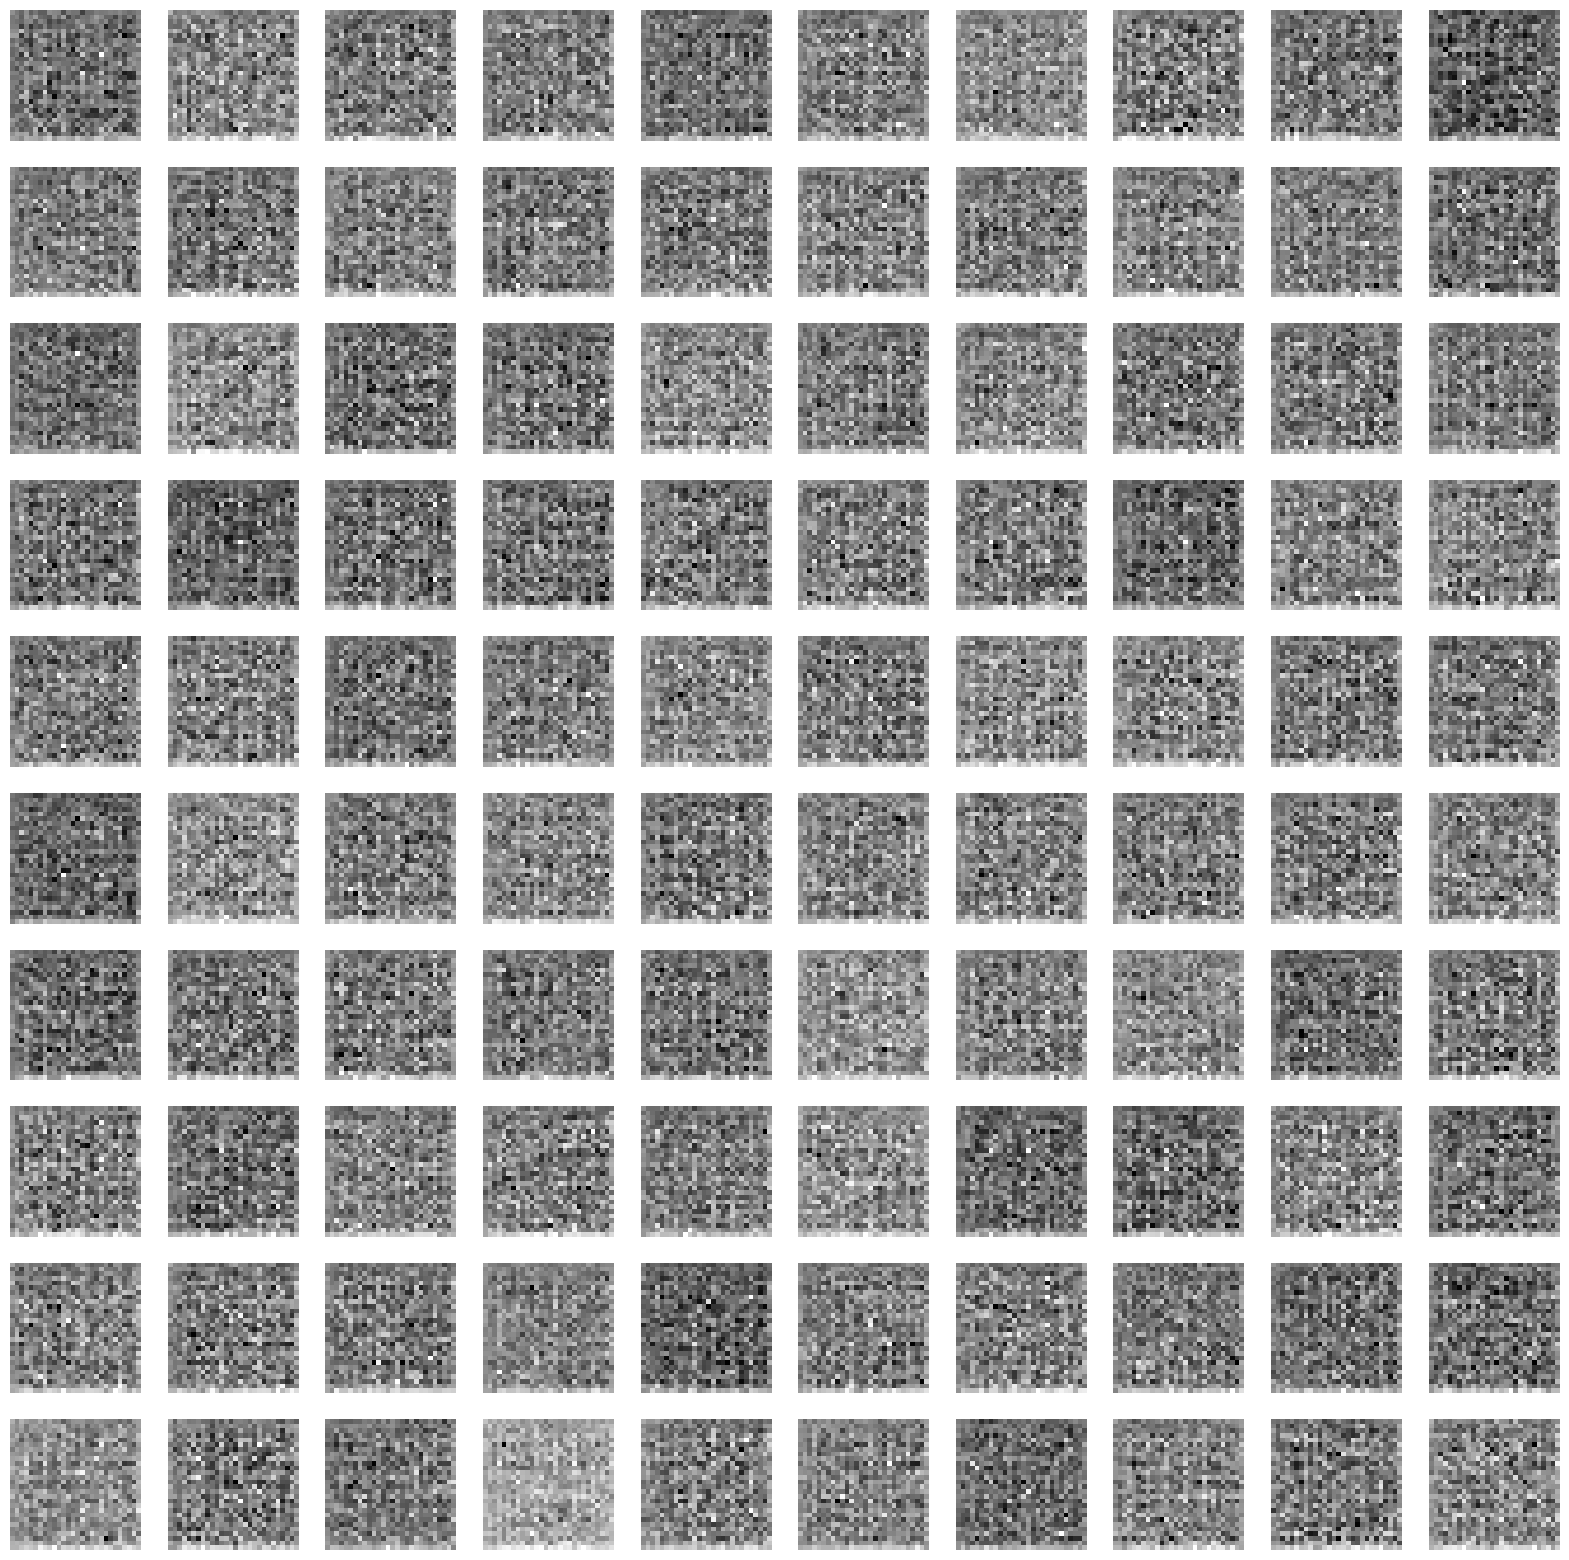

In [16]:
NUM_CLASSES = 10

def generate_and_save_images(generator, epoch, num_samples_per_class=10, save=True):
    labels = np.eye(NUM_CLASSES, dtype=np.float32)  # Shape: (10, 10)
    labels = tf.convert_to_tensor(labels)
    
    noise = tf.random.normal([NUM_CLASSES * num_samples_per_class, NOISE_DIM])  # Shape: (100, 100)
    
    labels_expanded = tf.tile(labels, [num_samples_per_class, 1])  # Shape: (100, 10)
    
    predictions = generator([labels_expanded, noise], training=False)
    
    fig = plt.figure(figsize=(num_samples_per_class * 2, NUM_CLASSES * 2))
    
    for i in range(NUM_CLASSES):
        for j in range(num_samples_per_class):
            idx = i * num_samples_per_class + j
            plt.subplot(NUM_CLASSES, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(predictions[idx, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
    
    if save:
        plt.savefig(f"img_epoch_{epoch:04d}.png")
    plt.show()
    
generate_and_save_images(generator_model, 1)

In [17]:
import time
from tqdm import tqdm
from IPython import display

In [20]:
EPOCHS = 500

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch, label_batch in tqdm(dataset):
            train_step(generator_model, discriminator_model,image_batch, label_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator_model, epoch+1, save=True)
    
    print(f"Epoch {epoch + 1}: {time.time() - start} seconds")

    generate_and_save_images(generator_model, epochs, seed, save=True)

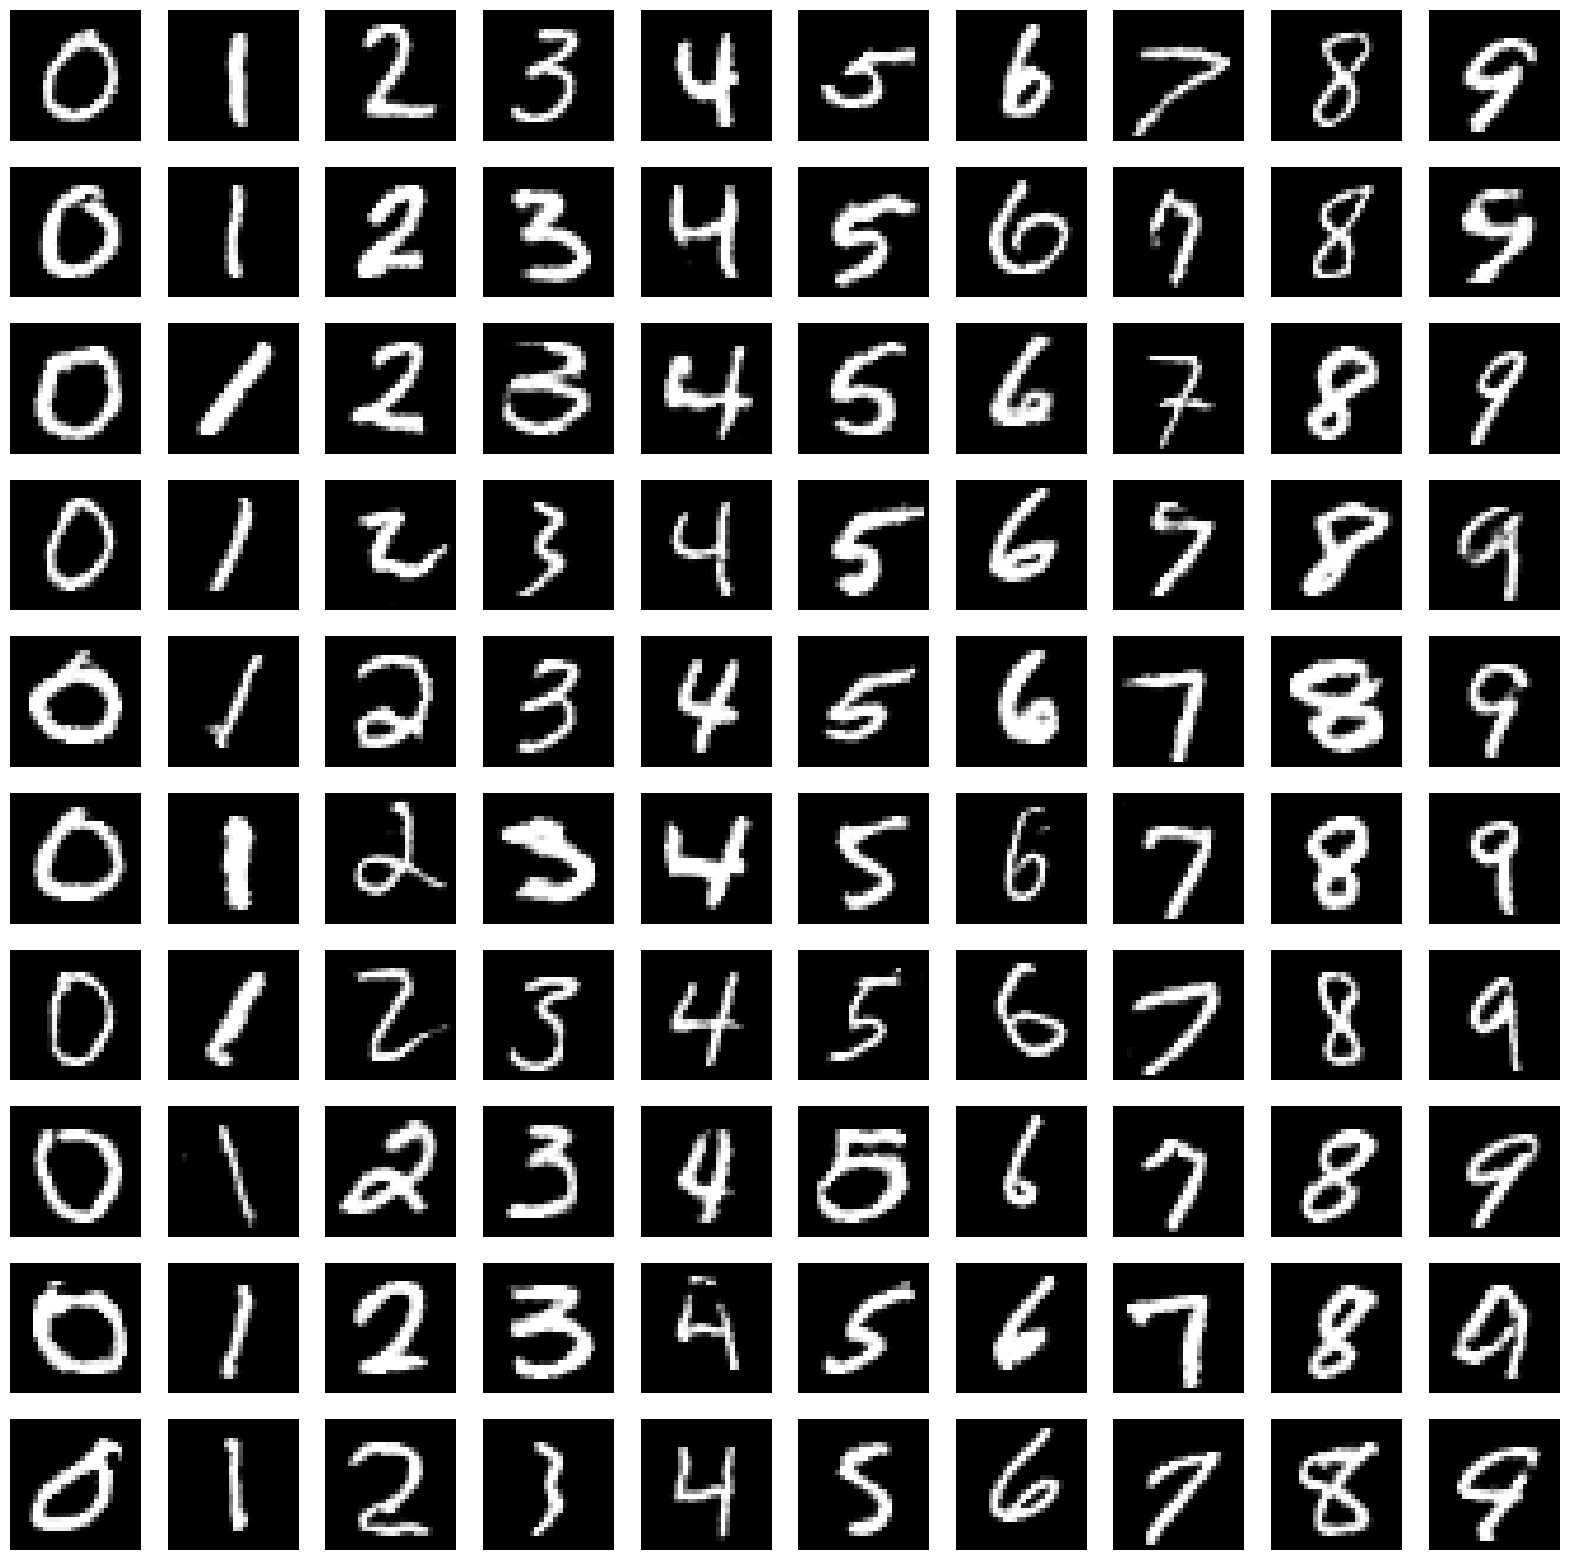

 65%|██████▌   | 307/469 [00:10<00:05, 30.30it/s]


KeyboardInterrupt: 

In [21]:
train(dataset, EPOCHS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


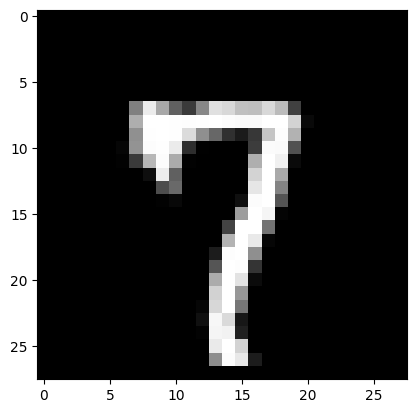

In [24]:
noise = np.random.normal(0, 1, (1, 100))
labels = tf.keras.utils.to_categorical([[7]], 10)

test_image = generator_model.predict([labels, noise])
plt.imshow(test_image[0, :, :, 0], cmap='gray')

In [25]:
generator_model.save("advanced_mnist_gan.keras")

In [26]:
!zip -r file.zip /kaggle/working

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/img_epoch_0034.png (deflated 26%)
  adding: kaggle/working/img_epoch_0108.png (deflated 29%)
  adding: kaggle/working/img_epoch_0065.png (deflated 29%)
  adding: kaggle/working/img_epoch_0035.png (deflated 27%)
  adding: kaggle/working/img_epoch_0050.png (deflated 28%)
  adding: kaggle/working/img_epoch_0036.png (deflated 26%)
  adding: kaggle/working/img_epoch_0142.png (deflated 30%)
  adding: kaggle/working/img_epoch_0067.png (deflated 29%)
  adding: kaggle/working/img_epoch_0078.png (deflated 29%)
  adding: kaggle/working/img_epoch_0145.png (deflated 30%)
  adding: kaggle/working/img_epoch_0125.png (deflated 30%)
  adding: kaggle/working/img_epoch_0054.png (deflated 29%)
  adding: kaggle/working/img_epoch_0038.png (deflated 29%)
  adding: kaggle/working/img_epoch_0153.png (deflated 30%)
  adding: kaggle/working/img_epoch_0133.png (deflated 30%)
  adding: kaggle/working/img_epoch_0002.png (deflated 26%)
  adding: kaggle/w